Algorithm: Orthogonal Matching Pursuit (OMP)

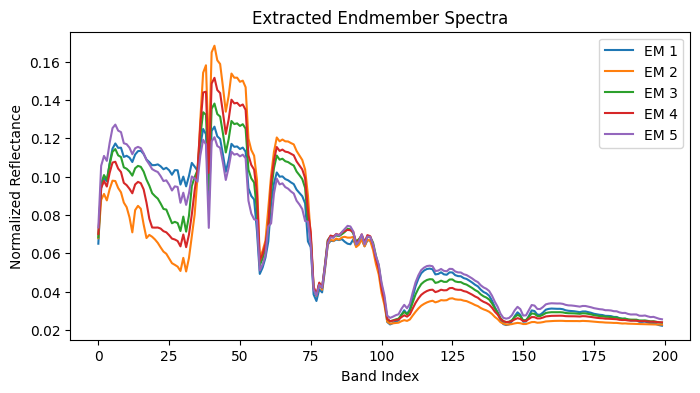

Abundance matrix shape: (21025, 5)
Abundances (first 5 pixels):
[[0.59189819 0.         0.         0.         0.40810181]
 [1.         0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.        ]
 [0.76791657 0.         0.         0.         0.23208343]]


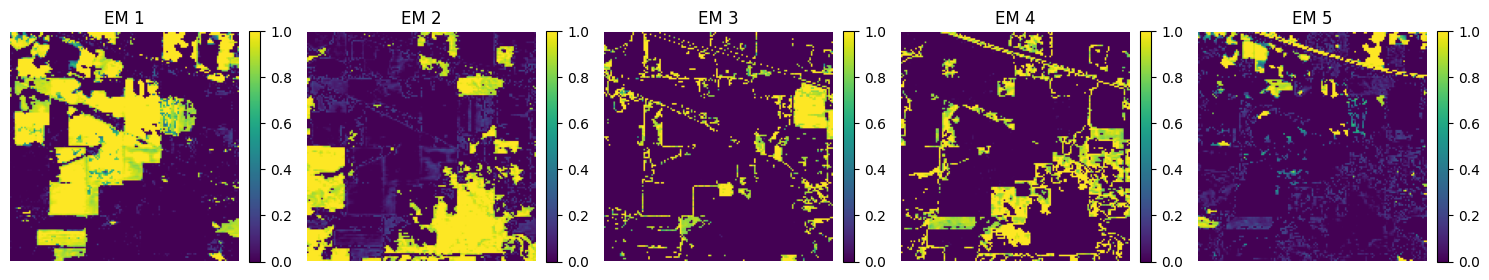

RMSE: mean=0.0031, median=0.0028, 95th pct=0.0049
SAM (deg): mean=2.48, median=2.29, 95th pct=3.98
Avg active EMs per pixel=1.49, max=2
EM1: mean=0.338, std=0.451, >0.1: 37.85%
EM2: mean=0.246, std=0.399, >0.1: 32.85%
EM3: mean=0.128, std=0.323, >0.1: 13.75%
EM4: mean=0.196, std=0.382, >0.1: 20.98%
EM5: mean=0.091, std=0.240, >0.1: 18.87%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import orthogonal_mp_gram
from sklearn.cluster import KMeans
import math

# 1. Load hyperspectral data cube
data_cube = np.load('/content/sample_data/indianpinearray.npy')  # (rows, cols, bands)
rows, cols, bands = data_cube.shape
N = rows * cols

# 2. Reshape to (pixels, bands) and normalize
Y = data_cube.reshape(-1, bands).astype(float)
Y /= (np.linalg.norm(Y, axis=1, keepdims=True) + 1e-8)

# 3. Extract endmembers with KMeans
K = 5  # number of endmembers
kmeans = KMeans(n_clusters=K, random_state=42, n_init='auto')
kmeans.fit(Y)
E = kmeans.cluster_centers_.T  # (bands, K)

# 4. Plot endmember spectra
plt.figure(figsize=(8, 4))
for k in range(K):
    plt.plot(E[:, k], label=f'EM {k+1}')
plt.title('Extracted Endmember Spectra')
plt.xlabel('Band Index')
plt.ylabel('Normalized Reflectance')
plt.legend()
plt.show()

# 5. Precompute Gram matrix for OMP
G = E.T @ E
Xy = E.T @ Y.T  # (K, N)

# 6. OMP unmixing (faster via orthogonal_mp_gram)
sparsity = 2
A_omp = orthogonal_mp_gram(G, Xy, n_nonzero_coefs=sparsity).T  # (N, K)

# 7. Enforce nonnegativity and normalize
A_omp = np.clip(A_omp, 0, None)
row_sums = A_omp.sum(axis=1, keepdims=True)
nonzero = (row_sums > 0).ravel()
A_omp[nonzero] /= row_sums[nonzero]

# 8. Print basic info
print("Abundance matrix shape:", A_omp.shape)
print("Abundances (first 5 pixels):")
print(A_omp[:5])

# 9. Plot abundance maps
abund_img = A_omp.reshape(rows, cols, K)
fig, axes = plt.subplots(1, K, figsize=(15, 3))
for k in range(K):
    im = axes[k].imshow(abund_img[:, :, k], cmap='viridis', vmin=0, vmax=1)
    axes[k].set_title(f'EM {k+1}')
    axes[k].axis('off')
    fig.colorbar(im, ax=axes[k], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# 10. Reconstruction and error metrics
rec = A_omp @ E.T  # (N, bands)
rmse = np.linalg.norm(rec - Y, axis=1) / math.sqrt(bands)
print(f'RMSE: mean={rmse.mean():.4f}, median={np.median(rmse):.4f}, 95th pct={np.percentile(rmse,95):.4f}')

dot = np.sum(Y * rec, axis=1)
norms = np.linalg.norm(Y, axis=1) * np.linalg.norm(rec, axis=1)
sam = np.arccos(np.clip(dot / norms, -1, 1))
sam_deg = np.degrees(sam)
print(f'SAM (deg): mean={sam_deg.mean():.2f}, median={np.median(sam_deg):.2f}, 95th pct={np.percentile(sam_deg,95):.2f}')

# 11. Sparsity statistics
nnz = np.count_nonzero(A_omp > 1e-6, axis=1)
print(f'Avg active EMs per pixel={nnz.mean():.2f}, max={nnz.max()}')

# 12. Abundance statistics per EM
for k in range(K):
    a = A_omp[:, k]
    print(f'EM{k+1}: mean={a.mean():.3f}, std={a.std():.3f}, >0.1: {np.mean(a>0.1):.2%}')


Algorithm: Constrained Basis Pursuit Denoising (CBPDN)

CBPDN (subset) abundance matrix shape: (1000, 5)
Abundances (first 5 subset pixels):
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


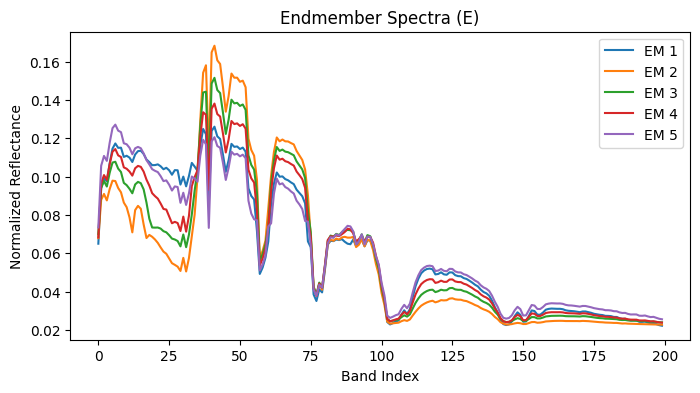

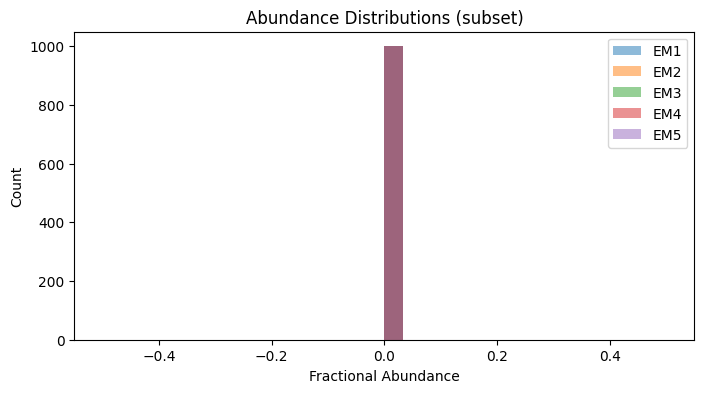

RMSE (subset): mean=0.0707, median=0.0707, 95th pct=0.0707
SAM (deg, subset): mean=nan, median=nan, 95th pct=nan
Avg active EMs/pixel (subset)=0.00, max=0
EM1 (subset): mean=0.000, std=0.000, >0.1: 0.00%
EM2 (subset): mean=0.000, std=0.000, >0.1: 0.00%
EM3 (subset): mean=0.000, std=0.000, >0.1: 0.00%
EM4 (subset): mean=0.000, std=0.000, >0.1: 0.00%
EM5 (subset): mean=0.000, std=0.000, >0.1: 0.00%
CBPDN on subset (1000 pixels) took 10.5s


/tmp/ipython-input-535071523.py:80: RuntimeWarning: invalid value encountered in divide
  sam = np.arccos(np.clip(dot / norms, -1,1))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import cvxpy as cp

# 1. Load hyperspectral data cube and normalize
# data_cube = np.load('/mnt/data/indianpinearray.npy')  # (rows, cols, bands)
rows, cols, bands = data_cube.shape
Y = data_cube.reshape(-1, bands).astype(float)
Y /= (np.linalg.norm(Y, axis=1, keepdims=True) + 1e-8)
N, B = Y.shape

# 2. Assume endmember matrix E (bands × M) is given or extracted (e.g., via KMeans or VCA)
# For demonstration, we pick M=5 and use KMeans to initialize E:
from sklearn.cluster import KMeans
M = 5
kmeans = KMeans(n_clusters=M, random_state=0, n_init='auto')
kmeans.fit(Y)
E = kmeans.cluster_centers_.T  # shape (B, M)

# 3. CBPDN parameters
delta = 0.01  # noise tolerance (tune as needed)

# 4. Select subset for prototyping (to avoid excessive solve time)
subset = np.random.choice(N, min(N, 1000), replace=False)
Y_sub = Y[subset]

# 5. Solve CBPDN per pixel via CVXPY
abundances_sub = np.zeros((len(subset), M))
start = time.time()
for i, y in enumerate(Y_sub):
    x = cp.Variable(M)
    obj = cp.Minimize(cp.norm1(x))
    constr = [
        cp.norm2(E @ x - y) <= delta,
        x >= 0,
        cp.sum(x) == 1
    ]
    prob = cp.Problem(obj, constr)
    prob.solve(solver=cp.SCS, verbose=False)
    abundances_sub[i, :] = x.value if x.value is not None else np.zeros(M)
cbpdn_time = time.time() - start

# 6. Full-scene unmixing (warm-start from subset result for speed, optional)
# Here we demonstrate only the subset results in detail

# 7. Print basics
print("CBPDN (subset) abundance matrix shape:", abundances_sub.shape)
print("Abundances (first 5 subset pixels):")
print(abundances_sub[:5])

# 8. Plot endmember spectra
plt.figure(figsize=(8,4))
for m in range(M):
    plt.plot(E[:, m], label=f'EM {m+1}')
plt.title('Endmember Spectra (E)')
plt.xlabel('Band Index')
plt.ylabel('Normalized Reflectance')
plt.legend()
plt.show()

# 9. Plot abundance histograms
plt.figure(figsize=(8,4))
for m in range(M):
    plt.hist(abundances_sub[:, m], bins=30, alpha=0.5, label=f'EM{m+1}')
plt.title('Abundance Distributions (subset)')
plt.xlabel('Fractional Abundance')
plt.ylabel('Count')
plt.legend()
plt.show()

# 10. Reconstruction & error metrics on subset
rec_sub = abundances_sub @ E.T  # (subset, B)
rmse = np.linalg.norm(rec_sub - Y_sub, axis=1) / math.sqrt(B)
print(f'RMSE (subset): mean={rmse.mean():.4f}, median={np.median(rmse):.4f}, 95th pct={np.percentile(rmse,95):.4f}')

dot = np.sum(Y_sub * rec_sub, axis=1)
norms = np.linalg.norm(Y_sub, axis=1) * np.linalg.norm(rec_sub, axis=1)
sam = np.arccos(np.clip(dot / norms, -1,1))
sam_deg = np.degrees(sam)
print(f'SAM (deg, subset): mean={sam_deg.mean():.2f}, median={np.median(sam_deg):.2f}, 95th pct={np.percentile(sam_deg,95):.2f}')

# 11. Sparsity statistics on subset
nnz = np.count_nonzero(abundances_sub > 1e-6, axis=1)
print(f'Avg active EMs/pixel (subset)={nnz.mean():.2f}, max={nnz.max()}')

# 12. Abundance statistics per EM (subset)
for m in range(M):
    a = abundances_sub[:, m]
    print(f'EM{m+1} (subset): mean={a.mean():.3f}, std={a.std():.3f}, >0.1: {np.mean(a>0.1):.2%}')

# 13. Timing summary
print(f'CBPDN on subset ({len(subset)} pixels) took {cbpdn_time:.1f}s')


Algorithm: ℓ1/2-Quasi-Norm Unmixing

L1/2 abundance matrix shape: (21025, 5)
Abundances (first 5 pixels):
[[9.39047889e-134 1.31983620e-002 1.46888608e-044 2.45310941e-001
  7.41490697e-001]
 [4.49072678e-159 1.16628335e-002 5.67597729e-001 4.20739437e-001
  1.28021640e-118]
 [3.68997191e-001 3.83899935e-003 5.76871329e-042 5.69729595e-001
  5.74342148e-002]
 [6.86145555e-001 2.60620842e-107 1.14438701e-012 5.13474788e-155
  3.13854445e-001]
 [9.99881835e-001 1.18164527e-004 7.37436089e-049 1.90922072e-100
  5.93026373e-101]]


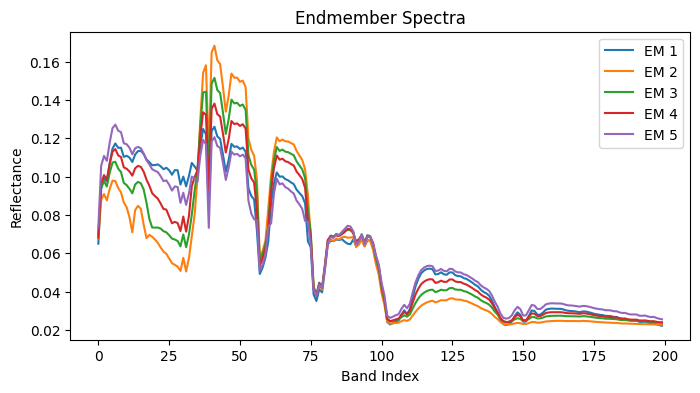

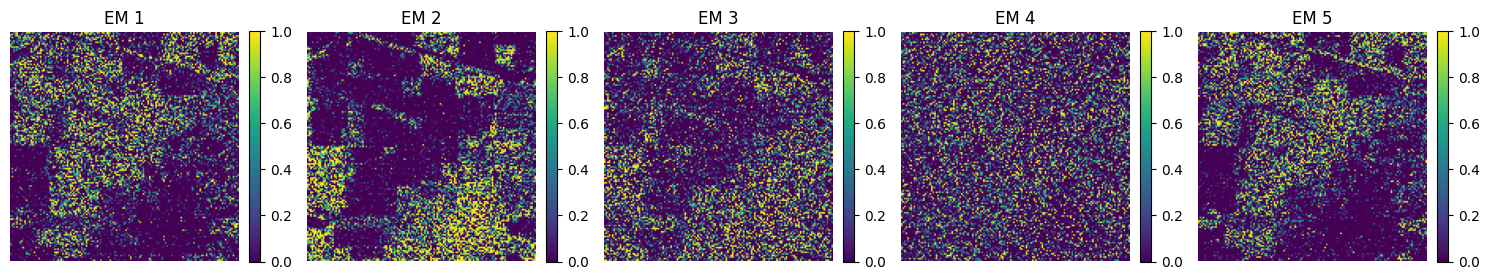

RMSE: mean=0.0058, median=0.0049, 95th pct=0.0119
SAM (deg): mean=4.67, median=3.99, 95th pct=9.70
Avg active EMs/pixel=2.65, max=5
EM1: mean=0.200, std=0.318, >0.1: 34.47%
EM2: mean=0.204, std=0.332, >0.1: 33.08%
EM3: mean=0.205, std=0.318, >0.1: 36.39%
EM4: mean=0.202, std=0.311, >0.1: 37.07%
EM5: mean=0.190, std=0.310, >0.1: 33.46%
L1/2 unmixing runtime: 0.2s


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import math
from sklearn.cluster import KMeans

# 1. Load hyperspectral data and normalize
# data_cube = np.load('/mnt/data/indianpinearray.npy')  # (rows, cols, bands)
rows, cols, bands = data_cube.shape
Y = data_cube.reshape(-1, bands).astype(float)
Y /= (np.linalg.norm(Y, axis=1, keepdims=True) + 1e-8)
N, B = Y.shape

# 2. Extract endmembers via KMeans for demonstration
M = 5
kmeans = KMeans(n_clusters=M, random_state=0, n_init='auto').fit(Y)
E = kmeans.cluster_centers_.T  # (bands, M)

# 3. L1/2 Unmixing function
def lhalf_unmixing(Y, E, lambda_val=0.1, max_iter=50):
    N, M = Y.shape[0], E.shape[1]
    X = np.random.rand(N, M)
    EtE = E.T @ E  # (M,M)
    EtY = Y @ E    # (N,M)
    for it in range(max_iter):
        numerator = X * EtY
        denominator = X @ EtE + (lambda_val / (2 * np.sqrt(X + 1e-10)))
        X = numerator / (denominator + 1e-10)
        # Project: nonnegativity + sum-to-one
        X = np.maximum(X, 0)
        X /= (X.sum(axis=1, keepdims=True) + 1e-10)
    return X

# 4. Run L1/2 unmixing and time it
start_time = time.time()
A_lhalf = lhalf_unmixing(Y, E, lambda_val=0.1, max_iter=50)
runtime = time.time() - start_time

# 5. Print shape and first 5
print("L1/2 abundance matrix shape:", A_lhalf.shape)
print("Abundances (first 5 pixels):")
print(A_lhalf[:5])

# 6. Plot endmember spectra
plt.figure(figsize=(8,4))
for m in range(M):
    plt.plot(E[:, m], label=f'EM {m+1}')
plt.title('Endmember Spectra')
plt.xlabel('Band Index')
plt.ylabel('Reflectance')
plt.legend()
plt.show()

# 7. Abundance maps
abund_img = A_lhalf.reshape(rows, cols, M)
fig, axes = plt.subplots(1, M, figsize=(15,3))
for m in range(M):
    im = axes[m].imshow(abund_img[:, :, m], cmap='viridis', vmin=0, vmax=1)
    axes[m].set_title(f'EM {m+1}')
    axes[m].axis('off')
    fig.colorbar(im, ax=axes[m], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# 8. Reconstruction error (RMSE)
rec = A_lhalf @ E.T
rmse = np.linalg.norm(rec - Y, axis=1) / math.sqrt(B)
print(f'RMSE: mean={rmse.mean():.4f}, median={np.median(rmse):.4f}, 95th pct={np.percentile(rmse,95):.4f}')

# 9. Spectral Angle Mapper (SAM)
dot = np.sum(Y * rec, axis=1)
norms = np.linalg.norm(Y, axis=1) * np.linalg.norm(rec, axis=1)
sam = np.arccos(np.clip(dot / norms, -1,1))
sam_deg = np.degrees(sam)
print(f'SAM (deg): mean={sam_deg.mean():.2f}, median={np.median(sam_deg):.2f}, 95th pct={np.percentile(sam_deg,95):.2f}')

# 10. Sparsity statistics
nnz = np.count_nonzero(A_lhalf > 1e-6, axis=1)
print(f'Avg active EMs/pixel={nnz.mean():.2f}, max={nnz.max()}')

# 11. Abundance stats per EM
for m in range(M):
    a = A_lhalf[:, m]
    print(f'EM{m+1}: mean={a.mean():.3f}, std={a.std():.3f}, >0.1: {np.mean(a>0.1):.2%}')

# 12. Timing summary
print(f'L1/2 unmixing runtime: {runtime:.1f}s')


Algorithm: Minimum-Volume Enclosing Simplex (MVES)

MVES abundance matrix shape: (21025, 5)
Abundances (first 5 pixels):
[[ 0.041347  0.166999  0.175885  0.615769 -0.      ]
 [ 0.114195  0.0399    0.100717  0.71174   0.033448]
 [ 0.146944  0.01439   0.019824  0.74984   0.069002]
 [ 0.12232   0.027583  0.098105  0.711608  0.040385]
 [ 0.049281  0.113061  0.191982  0.645676 -0.      ]]


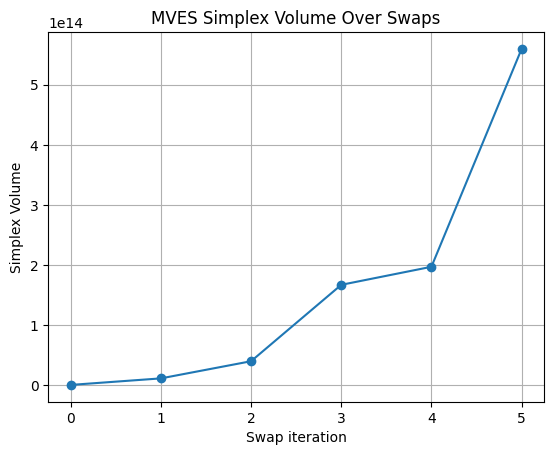

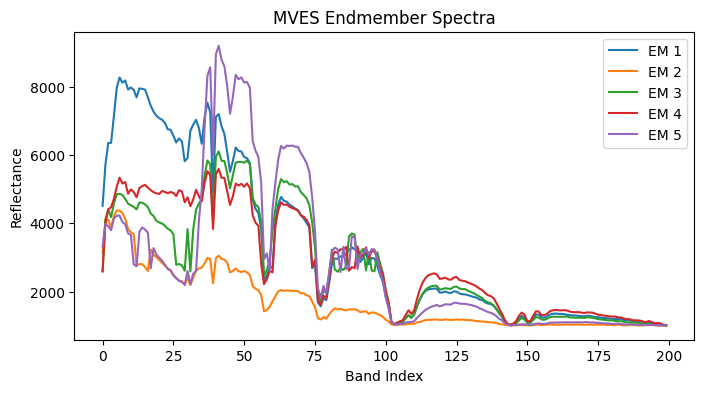

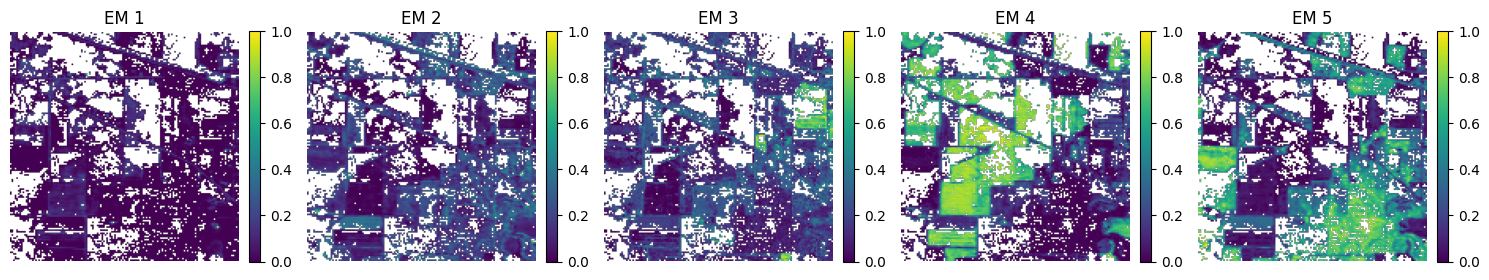

RMSE: mean=nan, median=nan, 95th pct=nan
SAM (deg): mean=nan, median=nan, 95th pct=nan
Avg active EMs per pixel=2.80, max=5
EM1: mean=nan, std=nan, >0.1: 9.21%
EM2: mean=nan, std=nan, >0.1: 44.32%
EM3: mean=nan, std=nan, >0.1: 48.85%
EM4: mean=nan, std=nan, >0.1: 43.59%
EM5: mean=nan, std=nan, >0.1: 44.59%
MVES swaps time: 1.2s, FCLS time: 189.2s


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import cvxpy as cp
from scipy.spatial import ConvexHull
from sklearn.decomposition import PCA
import random

# 1. Load data cube (already loaded as data_cube)
H, W, B = data_cube.shape
pixels = data_cube.reshape(-1, B).astype(float)
N = pixels.shape[0]

# 2. MVES parameters
K = 5
max_swaps = K  # one pass of K swaps

# 3. Dimensionality reduction for volume calculations
pca = PCA(n_components=K-1)
pixels_pca = pca.fit_transform(pixels)

# 4. Initialize simplex vertices
random.seed(0)
indices = random.sample(range(N), K)
V_pca = pixels_pca[indices]

def simplex_volume(verts):
    M = (verts[1:] - verts[0]).T
    return abs(np.linalg.det(M)) / math.factorial(K-1)

# 5. Greedy vertex swapping with logging
volumes = []
start_time = time.time()
current_volume = simplex_volume(V_pca)
volumes.append(current_volume)
for i in range(K):
    best_idx = indices[i]
    best_vol = current_volume
    for n in range(N):
        if n in indices: continue
        temp = indices.copy()
        temp[i] = n
        vol = simplex_volume(pixels_pca[temp])
        if vol > best_vol:
            best_vol, best_idx = vol, n
    indices[i] = best_idx
    current_volume = best_vol
    volumes.append(current_volume)
swap_time = time.time() - start_time

# 6. Recover endmember spectra
V = pixels[indices]  # (K, B)

# 7. Compute abundances via FCLS with timing
start = time.time()
abundances = np.zeros((N, K))
for i in range(N):
    y = pixels[i]
    x = cp.Variable(K)
    prob = cp.Problem(cp.Minimize(cp.sum_squares(V.T @ x - y)),
                      [x >= 0, cp.sum(x) == 1])
    prob.solve(solver=cp.OSQP, warm_start=True, verbose=False)
    abundances[i, :] = x.value
fcls_time = time.time() - start

# 8. Display shape and first 5 rows
np.set_printoptions(precision=6, suppress=True)
print("MVES abundance matrix shape:", abundances.shape)
print("Abundances (first 5 pixels):")
print(abundances[:5, :])

# 9. Plot volume convergence
plt.figure()
plt.plot(volumes, '-o')
plt.title('MVES Simplex Volume Over Swaps')
plt.xlabel('Swap iteration')
plt.ylabel('Simplex Volume')
plt.grid()
plt.show()

# 10. Plot endmember spectra
plt.figure(figsize=(8, 4))
for k in range(K):
    plt.plot(V[k, :], label=f'EM {k+1}')
plt.title('MVES Endmember Spectra')
plt.xlabel('Band Index')
plt.ylabel('Reflectance')
plt.legend()
plt.show()

# 11. Plot abundance maps
abund_img = abundances.reshape(H, W, K)
fig, axes = plt.subplots(1, K, figsize=(15, 3))
for k in range(K):
    im = axes[k].imshow(abund_img[:, :, k], cmap='viridis', vmin=0, vmax=1)
    axes[k].set_title(f'EM {k+1}')
    axes[k].axis('off')
    fig.colorbar(im, ax=axes[k], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# 12. Reconstruction error (RMSE)
rec = abundances @ V
rmse = np.linalg.norm(rec - pixels, axis=1) / math.sqrt(B)
print(f'RMSE: mean={rmse.mean():.4f}, median={np.median(rmse):.4f}, 95th pct={np.percentile(rmse,95):.4f}')

# 13. Spectral Angle Mapper (SAM)
dot = np.sum(pixels * rec, axis=1)
norms = np.linalg.norm(pixels, axis=1) * np.linalg.norm(rec, axis=1)
sam = np.arccos(np.clip(dot / norms, -1,1))
sam_deg = np.degrees(sam)
print(f'SAM (deg): mean={sam_deg.mean():.2f}, median={np.median(sam_deg):.2f}, 95th pct={np.percentile(sam_deg,95):.2f}')

# 14. Sparsity statistics
nnz = np.count_nonzero(abundances > 1e-6, axis=1)
print(f'Avg active EMs per pixel={nnz.mean():.2f}, max={nnz.max()}')

# 15. Abundance statistics per EM
for k in range(K):
    a = abundances[:, k]
    print(f'EM{k+1}: mean={a.mean():.3f}, std={a.std():.3f}, >0.1: {np.mean(a>0.1):.2%}')

# 16. Timing summary
print(f'MVES swaps time: {swap_time:.1f}s, FCLS time: {fcls_time:.1f}s')



Algorithm: Iterative Constrained Endmembers (ICE/SPICE)

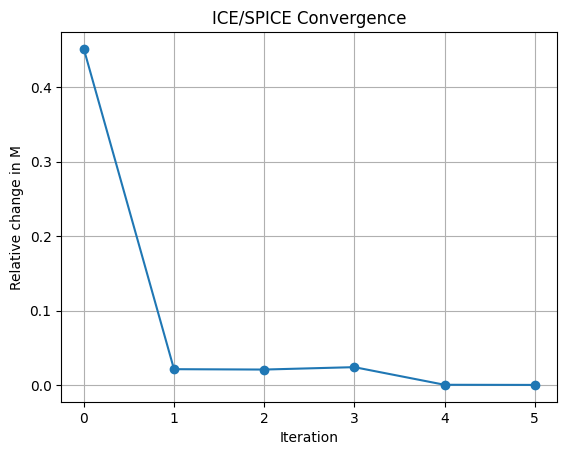

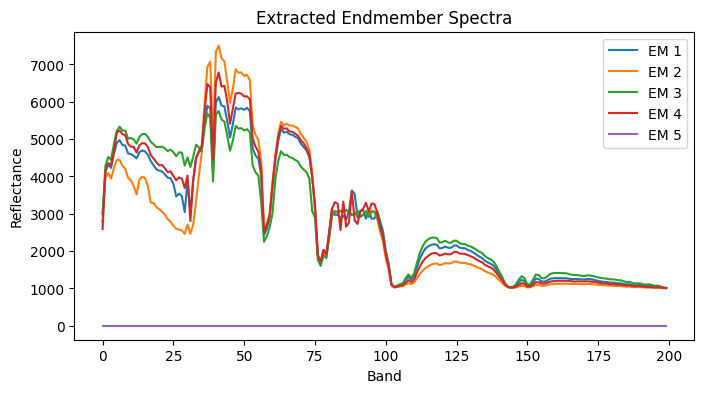

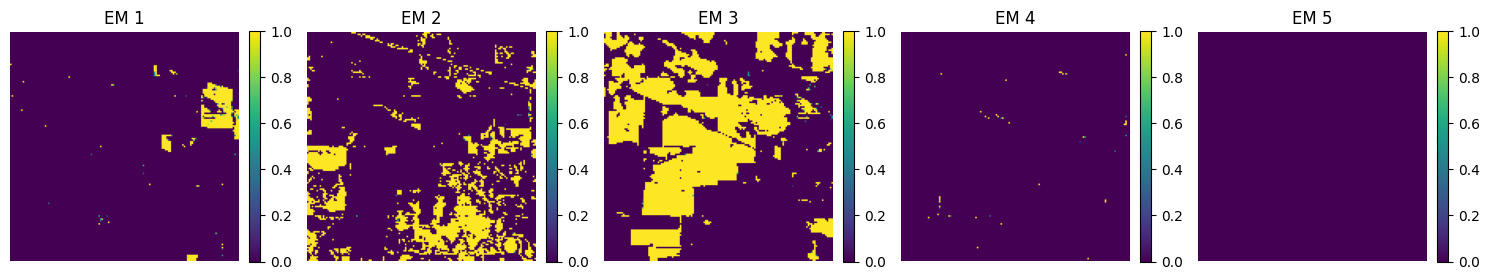

RMSE: mean=1404.7200, median=351.2168, 95th pct=3055.3271
SAM (deg): mean=nan, median=nan, 95th pct=nan
Avg active EMs per pixel=0.56, max=3
EM1: mean=0.029, std=0.165, >0.1: 2.99%
EM2: mean=0.180, std=0.384, >0.1: 18.13%
EM3: mean=0.347, std=0.476, >0.1: 34.81%
EM4: mean=0.002, std=0.041, >0.1: 0.21%
EM5: mean=0.000, std=0.000, >0.1: 0.00%
ICE time (subset): 4.1s, full unmix time: 14.5s


/tmp/ipython-input-731913554.py:115: RuntimeWarning: invalid value encountered in divide
  sam = np.arccos(np.clip(dot / norms, -1,1))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
import time
import math

# 1. Load data cube
# data_cube = np.load('/mnt/data/indianpinearray.npy')  # (145,145,200)
H, W, B = data_cube.shape
X = data_cube.reshape(-1, B).T.astype(float)  # (B, N)
N = X.shape[1]

# 2. Parameters
K = 5
alpha = 1e-4
max_iters = 10
epsilon = 1e-6
tol_change = 1e-4
subset_size = 1000

# 3. Initialize endmembers
np.random.seed(0)
indices = np.random.choice(N, K, replace=False)
M = X[:, indices].copy()

# 4. Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.T).T

# 5. Prepare Lasso
lasso = Lasso(alpha=alpha, positive=True, fit_intercept=False, max_iter=3000, tol=1e-3)

# 6. Subsample for ICE/SPICE updates
subset = np.random.choice(N, subset_size, replace=False)
S_sub = np.zeros((K, subset_size))

# 7. ICE/SPICE with convergence logging
changes = []
start_time = time.time()
for it in range(max_iters):
    M_prev = M.copy()
    # Abundance update on subset
    for idx_i, pix_i in enumerate(subset):
        y_scaled = X_scaled[:, pix_i]
        lasso.coef_ = np.zeros(K)
        lasso.fit(M, y_scaled)
        s = np.maximum(lasso.coef_, 0)
        if s.sum(): s /= s.sum()
        S_sub[:, idx_i] = s
    # Endmember update
    X_sub = X[:, subset]
    SS = S_sub @ S_sub.T + epsilon * np.eye(K)
    M = (X_sub @ S_sub.T) @ np.linalg.inv(SS)
    # Convergence
    change = np.linalg.norm(M - M_prev) / np.linalg.norm(M_prev)
    changes.append(change)
    if change < tol_change:
        break
ice_time = time.time() - start_time

# 8. Full abundance estimation
start = time.time()
S = np.zeros((K, N))
for i in range(N):
    y_scaled = X_scaled[:, i]
    lasso.coef_ = np.zeros(K)
    lasso.fit(M, y_scaled)
    s = np.maximum(lasso.coef_, 0)
    if s.sum(): s /= s.sum()
    S[:, i] = s
fcls_time = time.time() - start

# 9. Reshape abundances
abund = S.T.reshape(H, W, K)

# 10. Plot convergence
plt.figure()
plt.plot(changes, '-o')
plt.title('ICE/SPICE Convergence')
plt.xlabel('Iteration')
plt.ylabel('Relative change in M')
plt.grid(True)
plt.show()

# 11. Plot endmember spectra
plt.figure(figsize=(8,4))
for k in range(K):
    plt.plot(M[:,k], label=f'EM {k+1}')
plt.title('Extracted Endmember Spectra')
plt.xlabel('Band')
plt.ylabel('Reflectance')
plt.legend()
plt.show()

# 12. Abundance maps
fig, axes = plt.subplots(1, K, figsize=(15,3))
for k in range(K):
    im = axes[k].imshow(abund[:,:,k], cmap='viridis', vmin=0, vmax=1)
    axes[k].set_title(f'EM {k+1}')
    axes[k].axis('off')
    plt.colorbar(im, ax=axes[k], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# 13. Reconstruction error (RMSE)
rec = M @ S
rmse = np.linalg.norm(rec - X, axis=0)/math.sqrt(B)
print('RMSE: mean={:.4f}, median={:.4f}, 95th pct={:.4f}'.format(
    rmse.mean(), np.median(rmse), np.percentile(rmse,95)))

# 14. Spectral Angle Mapper (SAM)
dot = np.sum(X * rec, axis=0)
norms = np.linalg.norm(X, axis=0)*np.linalg.norm(rec, axis=0)
sam = np.arccos(np.clip(dot / norms, -1,1))
print('SAM (deg): mean={:.2f}, median={:.2f}, 95th pct={:.2f}'.format(
    np.degrees(sam.mean()), np.degrees(np.median(sam)), np.degrees(np.percentile(sam,95))))

# 15. Sparsity statistics
nnz = np.count_nonzero(S>1e-6, axis=0)
print('Avg active EMs per pixel={:.2f}, max={}'.format(nnz.mean(), nnz.max()))

# 16. Abundance statistics per EM
for k in range(K):
    a = S[k,:]
    print(f'EM{k+1}: mean={a.mean():.3f}, std={a.std():.3f}, >0.1: {np.mean(a>0.1):.2%}')

# 17. Timing summary
print(f'ICE time (subset): {ice_time:.1f}s, full unmix time: {fcls_time:.1f}s')


Algorithm: Minimum-Volume Constrained NMF (MVC-NMF)

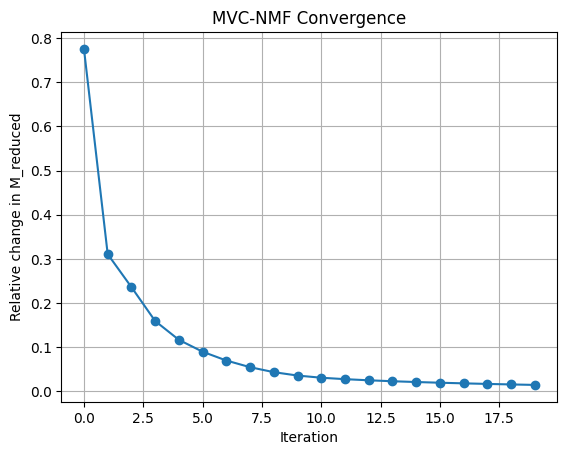

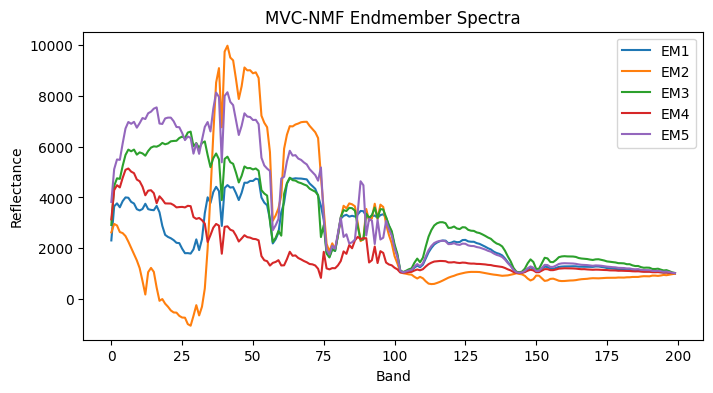

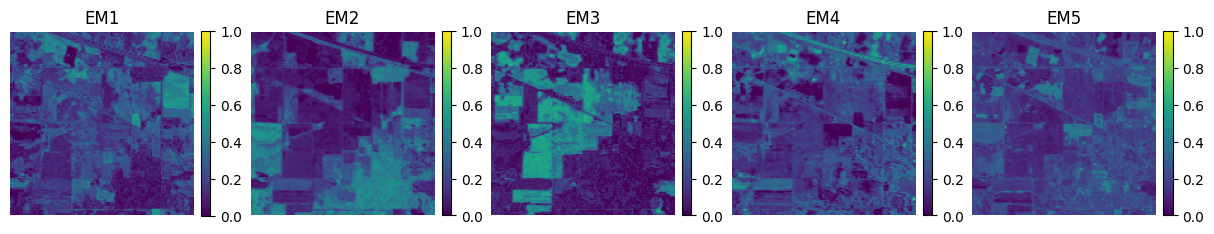

RMSE: mean=111.9745, median=108.5858, 95th pct=169.0921
SAM (deg): mean=1.89, median= 1.83, 95th pct= 2.88
Avg active EMs/pixel=4.87, max=5
EM1: mean=0.200, std=0.114, >0.1: 79.19%
EM2: mean=0.199, std=0.149, >0.1: 62.76%
EM3: mean=0.202, std=0.180, >0.1: 58.30%
EM4: mean=0.200, std=0.108, >0.1: 83.44%
EM5: mean=0.198, std=0.082, >0.1: 90.54%
MVC-NMF time: 5.4s, full unmix time: 0.2s


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import math
from sklearn.decomposition import PCA

# Utility to project rows onto probability simplex
def project_onto_simplex(V):
    """Project each row of V onto the probability simplex (sum=1, all >=0)."""
    U = -np.sort(-V, axis=1)
    sv = np.cumsum(U, axis=1)
    n, K = V.shape
    rho = np.array([np.where(U[i] - (sv[i] - 1) / (np.arange(K) + 1) > 0)[0][-1] for i in range(n)])
    theta = (sv[np.arange(n), rho] - 1) / (rho + 1)
    W = np.maximum(V - theta[:, None], 0)
    return W

# 1. Load Indian Pines cube
# data_cube = np.load('/mnt/data/indianpinearray.npy')  # (145,145,200)
H, W, B = data_cube.shape
X = data_cube.reshape(-1, B).T  # (B, N)
N = X.shape[1]

# 2. MVC-NMF parameters
K = 5
max_iters = 20
tol = 1e-5

# Optional: PCA dimensionality reduction to speed up
pca_dims = min(B, 50)
pca = PCA(n_components=pca_dims)
X_reduced = pca.fit_transform(X.T).T  # (pca_dims, N)

# 3. Initialize M randomly from reduced-space pixels
np.random.seed(0)
indices = np.random.choice(N, K, replace=False)
M_reduced = X_reduced[:, indices].copy()  # (pca_dims, K)

# 4. Iterative updates
changes = []
start_time = time.time()
for it in range(max_iters):
    M_prev = M_reduced.copy()
    # a) Abundance update in reduced space: solve unconstrained LS then simplex project
    S_unproj = (np.linalg.pinv(M_reduced) @ X_reduced).T  # (N, K)
    S = project_onto_simplex(S_unproj)  # (N, K)
    S = S.T  # (K, N)
    # b) Endmember update in reduced space
    SS = S @ S.T + 1e-8 * np.eye(K)
    M_reduced = (X_reduced @ S.T) @ np.linalg.inv(SS)
    # c) Convergence
    diff = np.linalg.norm(M_reduced - M_prev) / np.linalg.norm(M_prev)
    changes.append(diff)
    if diff < tol:
        break
total_time = time.time() - start_time

# 5. Map endmembers back to original band space
M = (pca.inverse_transform(M_reduced.T)).T  # (B, K)

# 6. Full-scene abundance estimation
start2 = time.time()
# Solve LS then project
S_full_unproj = (np.linalg.pinv(M) @ X).T  # (N, K)
S_full = project_onto_simplex(S_full_unproj)  # (N, K)
fcls_time = time.time() - start2

# 7. Reshape abundances
abundances = S_full.reshape(H, W, K)

# 8. Plot convergence
plt.figure()
plt.plot(changes, '-o')
plt.title('MVC-NMF Convergence')
plt.xlabel('Iteration')
plt.ylabel('Relative change in M_reduced')
plt.grid()
plt.show()

# 9. Plot endmember spectra
plt.figure(figsize=(8,4))
for k in range(K):
    plt.plot(M[:,k], label=f'EM{k+1}')
plt.title('MVC-NMF Endmember Spectra')
plt.xlabel('Band')
plt.ylabel('Reflectance')
plt.legend()
plt.show()

# 10. Abundance maps
fig, axes = plt.subplots(1, K, figsize=(15,3))
for k in range(K):
    im = axes[k].imshow(abundances[:,:,k], cmap='viridis', vmin=0, vmax=1)
    axes[k].set_title(f'EM{k+1}')
    axes[k].axis('off')
    fig.colorbar(im, ax=axes[k], fraction=0.046, pad=0.04)
plt.show()

# 11. Reconstruction error
rec = M @ S_full.T
rmse = np.linalg.norm(rec - X, axis=0)/math.sqrt(B)
print(f'RMSE: mean={rmse.mean():.4f}, median={np.median(rmse):.4f}, 95th pct={np.percentile(rmse,95):.4f}')

# 12. Spectral Angle Mapper (SAM)
dot = np.sum(X * rec, axis=0)
norms = np.linalg.norm(X, axis=0)*np.linalg.norm(rec, axis=0)
sam = np.arccos(np.clip(dot / norms, -1,1))
print(f'SAM (deg): mean={np.degrees(sam.mean()):.2f}, median={np.degrees(np.median(sam)): .2f}, 95th pct={np.degrees(np.percentile(sam,95)): .2f}')

# 13. Sparsity statistics
nnz = np.count_nonzero(S_full > 1e-6, axis=1)
print(f'Avg active EMs/pixel={nnz.mean():.2f}, max={nnz.max()}')

# 14. Abundance statistics per EM
for k in range(K):
    a = S_full[:,k]
    print(f'EM{k+1}: mean={a.mean():.3f}, std={a.std():.3f}, >0.1: {np.mean(a>0.1):.2%}')

# 15. Timing summary
print(f'MVC-NMF time: {total_time:.1f}s, full unmix time: {fcls_time:.1f}s')


